In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
noodulz_pokemon_dataset_1000_path = kagglehub.dataset_download('noodulz/pokemon-dataset-1000')

print('Data source import complete.')


Using Colab cache for faster access to the 'pokemon-dataset-1000' dataset.
Data source import complete.


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>🗂️1. Custom Datasets and DataLoaders 🗂️</b></font>
</div>

In [2]:
import os, torch, random, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):

    def __init__(self, root, data_type="train", cls_names=None, transformations=None):
        self.transformations = transformations

        # Collect image paths
        self.im_paths = glob(f"{root}/{data_type}/*/*.png")

        # IMPORTANT FIX: check None explicitly
        self.cls_names = {} if cls_names is None else cls_names
        self.cls_counts = {}

        # Continue indexing if cls_names already exists
        count = len(self.cls_names)

        for im_path in self.im_paths:
            cls_name = self.get_cls_name(im_path)

            if cls_name not in self.cls_names:
                self.cls_names[cls_name] = count
                count += 1

            self.cls_counts[cls_name] = self.cls_counts.get(cls_name, 0) + 1

        print(f"{data_type} classes:", len(self.cls_names),
              "| samples:", len(self.im_paths))

    def get_cls_name(self, path): return os.path.dirname(path).split("/")[-1]

    def __len__(self): return len(self.im_paths)

    def get_pos_neg_im_paths(self, qry_label):

        pos_im_paths = [im_path for im_path in self.im_paths if qry_label == self.get_cls_name(im_path)]
        neg_im_paths = [im_path for im_path in self.im_paths if qry_label != self.get_cls_name(im_path)]

        pos_rand_int = random.randint(a = 0, b = len(pos_im_paths) - 1)
        neg_rand_int = random.randint(a = 0, b = len(neg_im_paths) - 1)

        return pos_im_paths[pos_rand_int], neg_im_paths[neg_rand_int]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        qry_im = Image.open(im_path).convert("RGB")
        qry_label = self.get_cls_name(im_path)

        pos_im_path, neg_im_path = self.get_pos_neg_im_paths(qry_label = qry_label)
        pos_im, neg_im = Image.open(pos_im_path).convert("RGB"), Image.open(neg_im_path).convert("RGB")

        qry_gt = self.cls_names[qry_label]
        neg_gt = self.cls_names[self.get_cls_name(neg_im_path)]

        if self.transformations is not None: qry_im = self.transformations(qry_im); pos_im = self.transformations(pos_im); neg_im = self.transformations(neg_im)

        data = {}

        data["qry_im"] = qry_im
        data["qry_gt"] = qry_gt
        data["pos_im"] = pos_im
        data["neg_im"] = neg_im
        data["neg_gt"] = neg_gt

        return data

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    tr_ds     = CustomDataset(root = root, data_type = "train", transformations = transformations)
    cls_names = tr_ds.cls_names; cls_counts = tr_ds.cls_counts
    vl_ds     = CustomDataset(root = root, data_type = "val",  cls_names = cls_names, transformations = transformations)
    ts_ds     = CustomDataset(root = root, data_type = "test", cls_names = cls_names, transformations = transformations)

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, cls_names, [cls_counts, vl_ds.cls_counts, ts_ds.cls_counts]

root = noodulz_pokemon_dataset_1000_path + "/pokemon-dataset-1000"
mean, std, size, bs = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 16
tfs = T.Compose([T.ToTensor(), T.Resize(size = (size, size), antialias = False), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes, cls_counts = get_dls(root = root, transformations = tfs, bs = bs)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

train classes: 1000 | samples: 20921
val classes: 1000 | samples: 2379
test classes: 1000 | samples: 3239
1308
149
3239
{'whimsicott': 0, 'forretress': 1, 'mudbray': 2, 'camerupt': 3, 'ninjask': 4, 'deoxys-normal': 5, 'finizen': 6, 'obstagoon': 7, 'vivillon': 8, 'skarmory': 9, 'rockruff': 10, 'urshifu-single-strike': 11, 'tyranitar': 12, 'lumineon': 13, 'golbat': 14, 'torterra': 15, 'wurmple': 16, 'beedrill': 17, 'caterpie': 18, 'dusknoir': 19, 'quilladin': 20, 'clefable': 21, 'shiinotic': 22, 'appletun': 23, 'celebi': 24, 'doublade': 25, 'gumshoos': 26, 'sceptile': 27, 'cosmog': 28, 'dhelmise': 29, 'arctibax': 30, 'raichu': 31, 'sandslash': 32, 'metapod': 33, 'xatu': 34, 'drowzee': 35, 'kingdra': 36, 'roselia': 37, 'loudred': 38, 'oddish': 39, 'charizard': 40, 'klefki': 41, 'cacturne': 42, 'druddigon': 43, 'remoraid': 44, 'swadloon': 45, 'yanmega': 46, 'surskit': 47, 'vanillish': 48, 'mantyke': 49, 'rabsca': 50, 'tandemaus': 51, 'tauros': 52, 'ponyta': 53, 'regigigas': 54, 'swalot': 5

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 <div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>📈 2. Data Analysis 📈</b></font>
</div>

Data analysis is in process...



/tmp/ipython-input-947008563.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


Data analysis is in process...



/tmp/ipython-input-947008563.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


Data analysis is in process...



/tmp/ipython-input-947008563.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names)


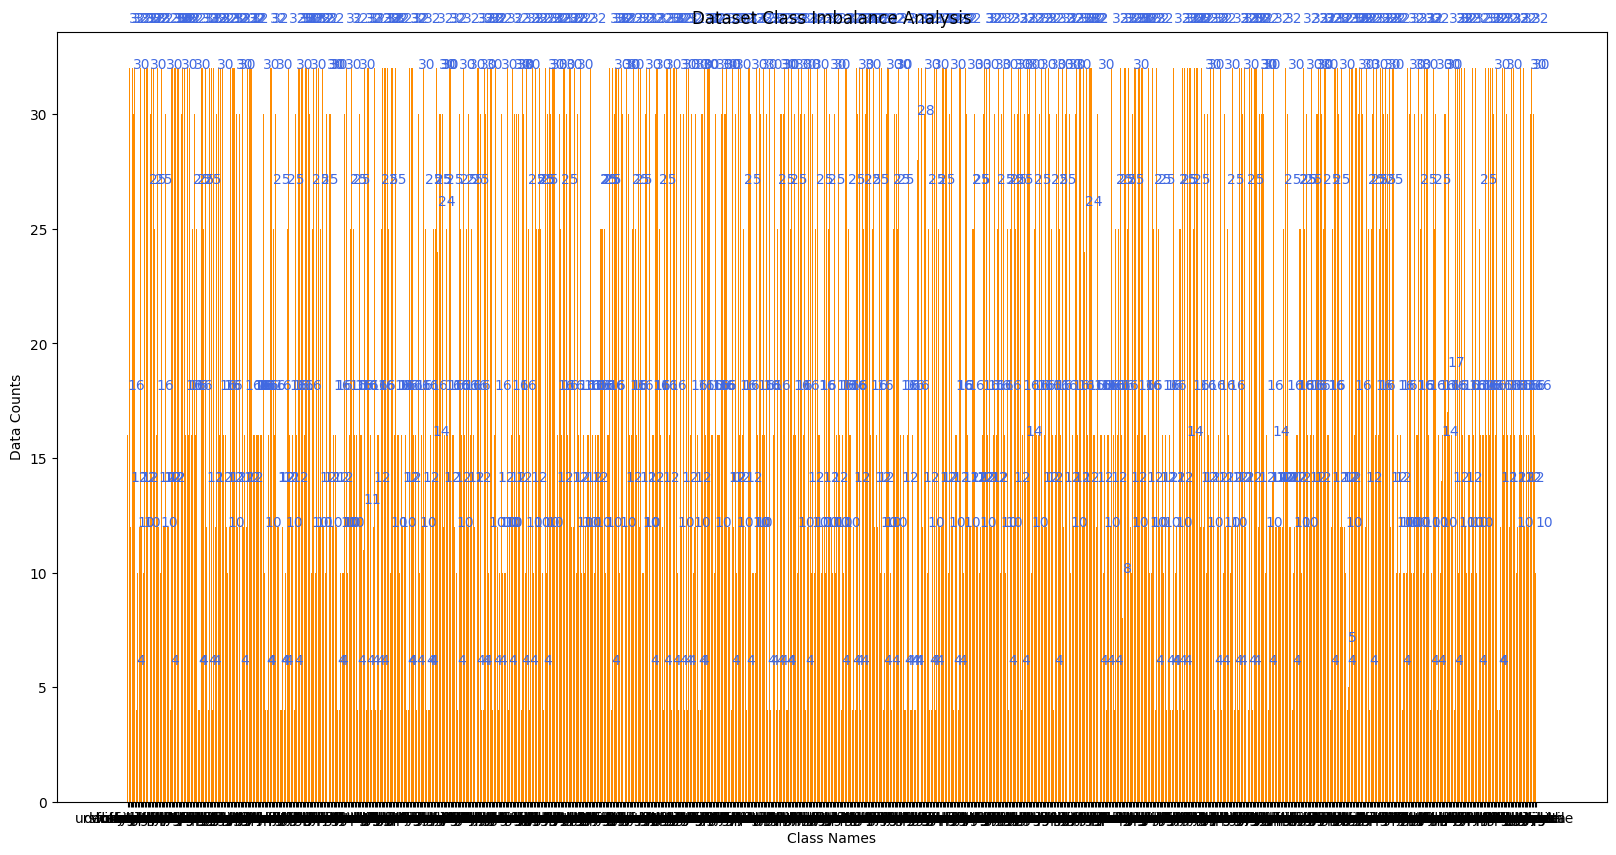

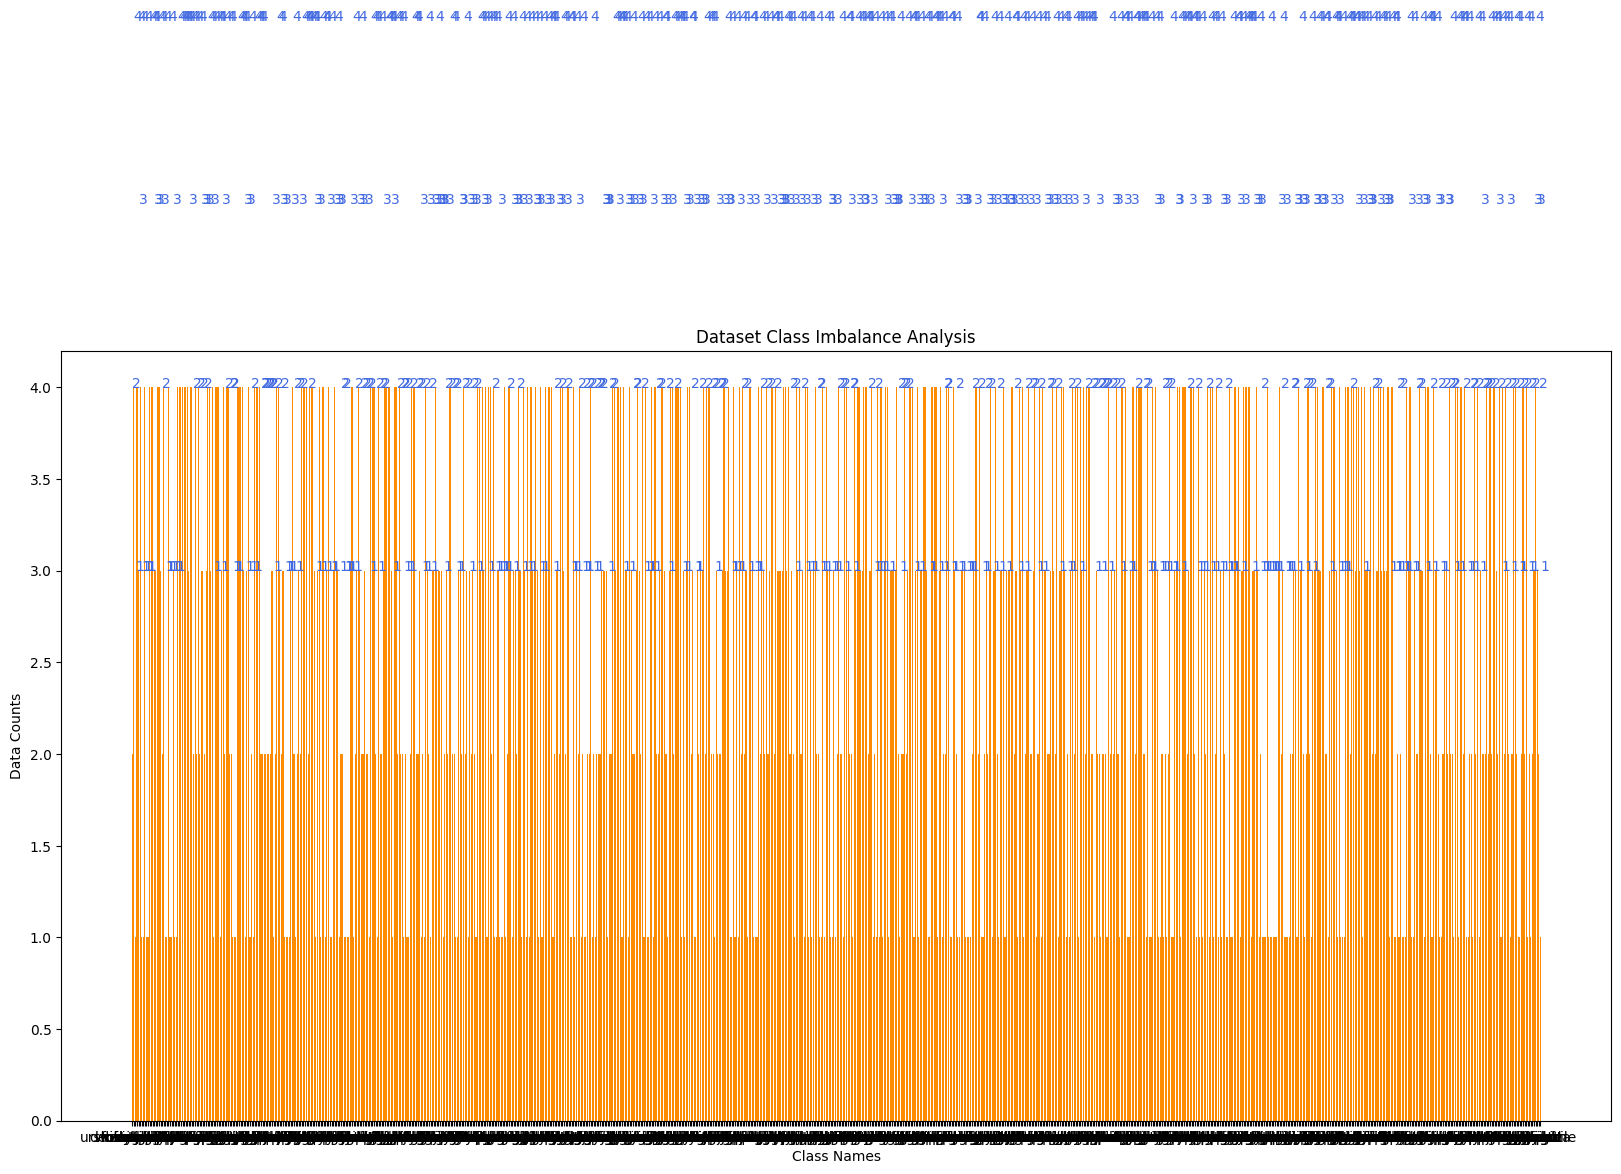

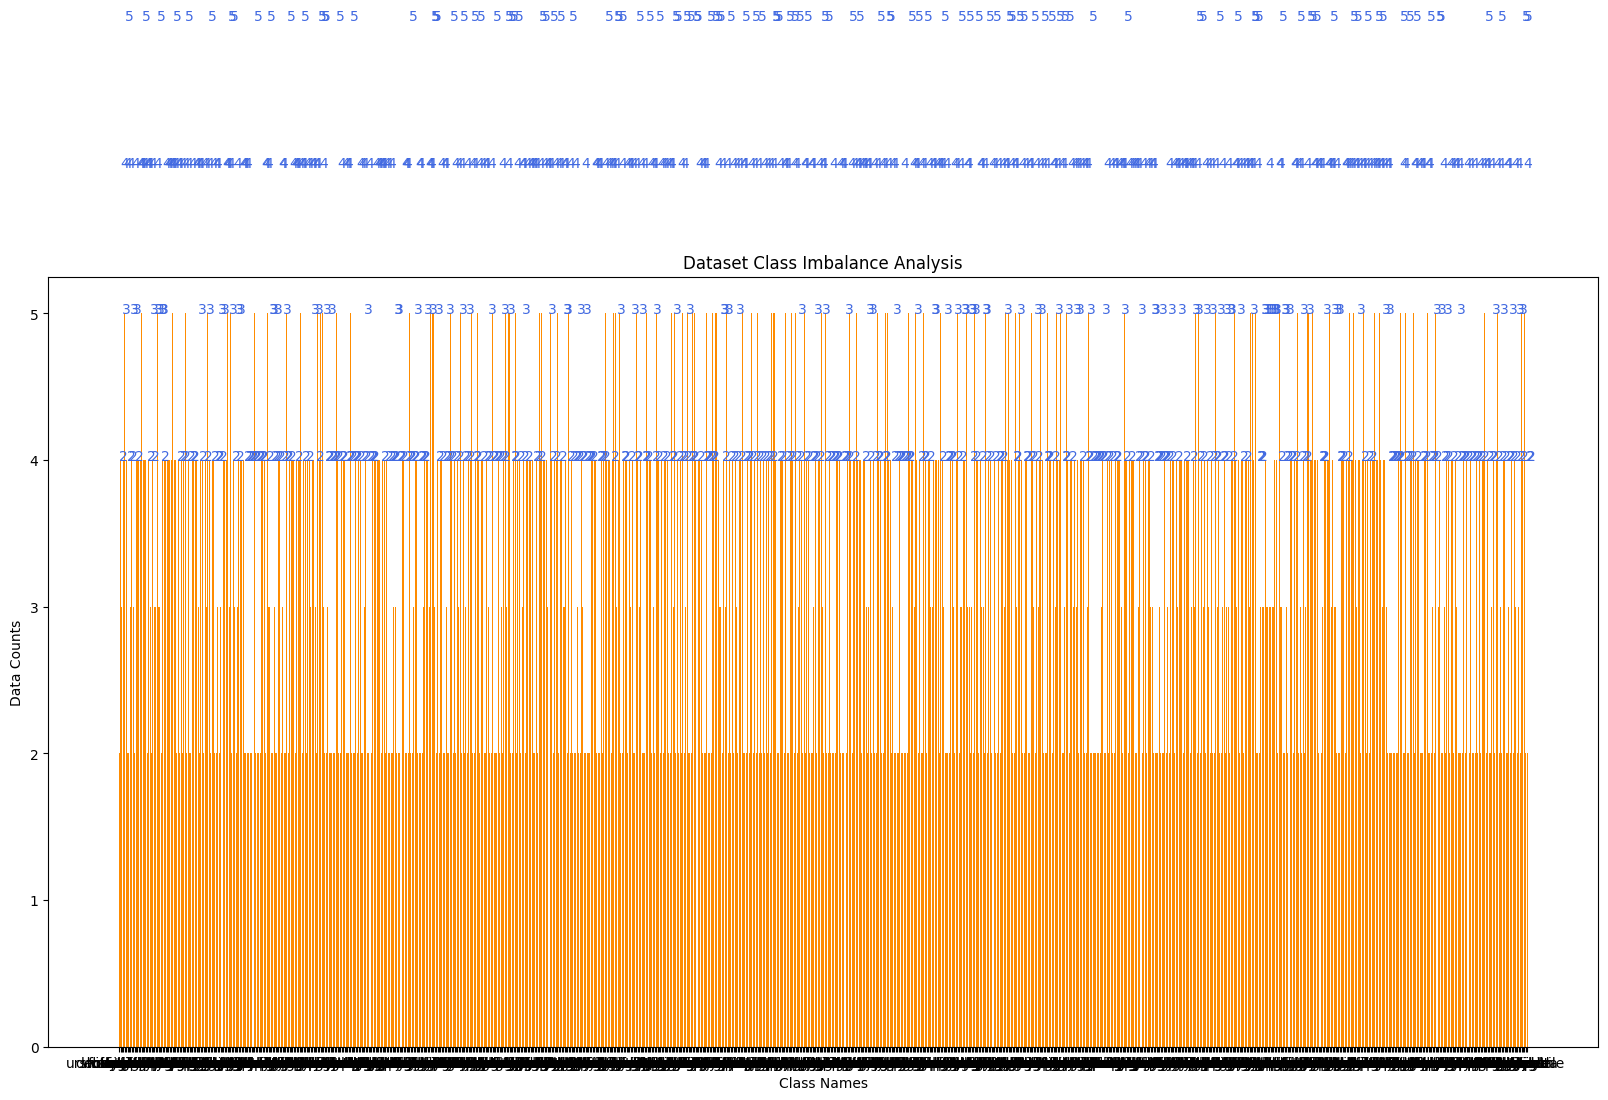

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms as T

class Visualization:

    def __init__(self, vis_datas, n_ims, rows, cmap = None, cls_names = None, cls_counts = None, t_type = "rgb"):

        self.n_ims, self.rows = n_ims, rows
        self.t_type, self.cmap,  = t_type, cmap
        self.cls_names = cls_names

        data_names = ["train", "val", "test"]
        self.vis_datas = {data_names[i]: vis_datas[i] for i in range(len(vis_datas))}
        if isinstance(cls_counts, list): self.analysis_datas = {data_names[i]: cls_counts[i] for i in range(len(cls_counts))}
        else: self.analysis_datas = {"all": cls_counts}

    def tn2np(self, t):

        gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
        rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

        invTrans = gray_tfs if self.t_type == "gray" else rgb_tfs

        return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if self.t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

    def plot(self, rows, cols, count, im, title = "Original Image"):

        plt.subplot(rows, cols, count)
        plt.imshow(self.tn2np(im))
        plt.axis("off"); plt.title(title)

        return count + 1

    def vis(self, data, save_name):

        print(f"{save_name.upper()} Data Visualization is in process...\n")
        assert self.cmap in ["rgb", "gray"], "Please choose rgb or gray cmap"
        if self.cmap == "rgb": cmap = "viridis"
        cols = self.n_ims // self.rows; count = 1

        plt.figure(figsize = (25, 20))

        indices = [np.random.randint(low = 0, high = len(data) - 1) for _ in range(self.n_ims)]

        for idx, index in enumerate(indices):

            if count == self.n_ims + 1: break

            meta_data = data[index]
            qry_im, pos_im, neg_im, qry_lbl, neg_lbl = meta_data["qry_im"], meta_data["pos_im"], meta_data["neg_im"], meta_data["qry_gt"], meta_data["neg_gt"]

            # First Plot
            count = self.plot(self.rows, cols, count, im = qry_im, title = f"Query Image \n Class -> {self.cls_names[qry_lbl]}")

            # Second Plot
            count = self.plot(self.rows, cols, count, im = pos_im, title = f"Positive Image \n Class -> {self.cls_names[qry_lbl]}")

            # Third Plot
            count = self.plot(self.rows, cols, count, im = neg_im, title = f"Negative Image \n Class -> {self.cls_names[neg_lbl]}")

        plt.show()

    def data_analysis(self, cls_counts, save_name):

        print("Data analysis is in process...\n")

        width, text_width, text_height = 0.7, 0.05, 2
        cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

        _, ax = plt.subplots(figsize = (20, 10))
        indices = np.arange(len(counts))

        ax.bar(indices, counts, width, color = "darkorange")
        ax.set_xlabel("Class Names", color = "black")
        ax.set_xticklabels(cls_names)
        ax.set(xticks = indices, xticklabels = cls_names)
        ax.set_ylabel("Data Counts", color = "black")
        ax.set_title(f"Dataset Class Imbalance Analysis")

        for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

    def visualization(self): [self.vis(data.dataset, save_name) for (save_name, data) in self.vis_datas.items()]

    def analysis(self): [self.data_analysis(data, save_name) for (save_name, data) in self.analysis_datas.items()]

vis = Visualization(vis_datas = [tr_dl, val_dl, ts_dl], n_ims = 18, rows = 6, cmap = "rgb", cls_names = list(classes.keys()), cls_counts = cls_counts)
vis.analysis()

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>📊 3. Data Visualization 📊</b></font>
</div>

TRAIN Data Visualization is in process...



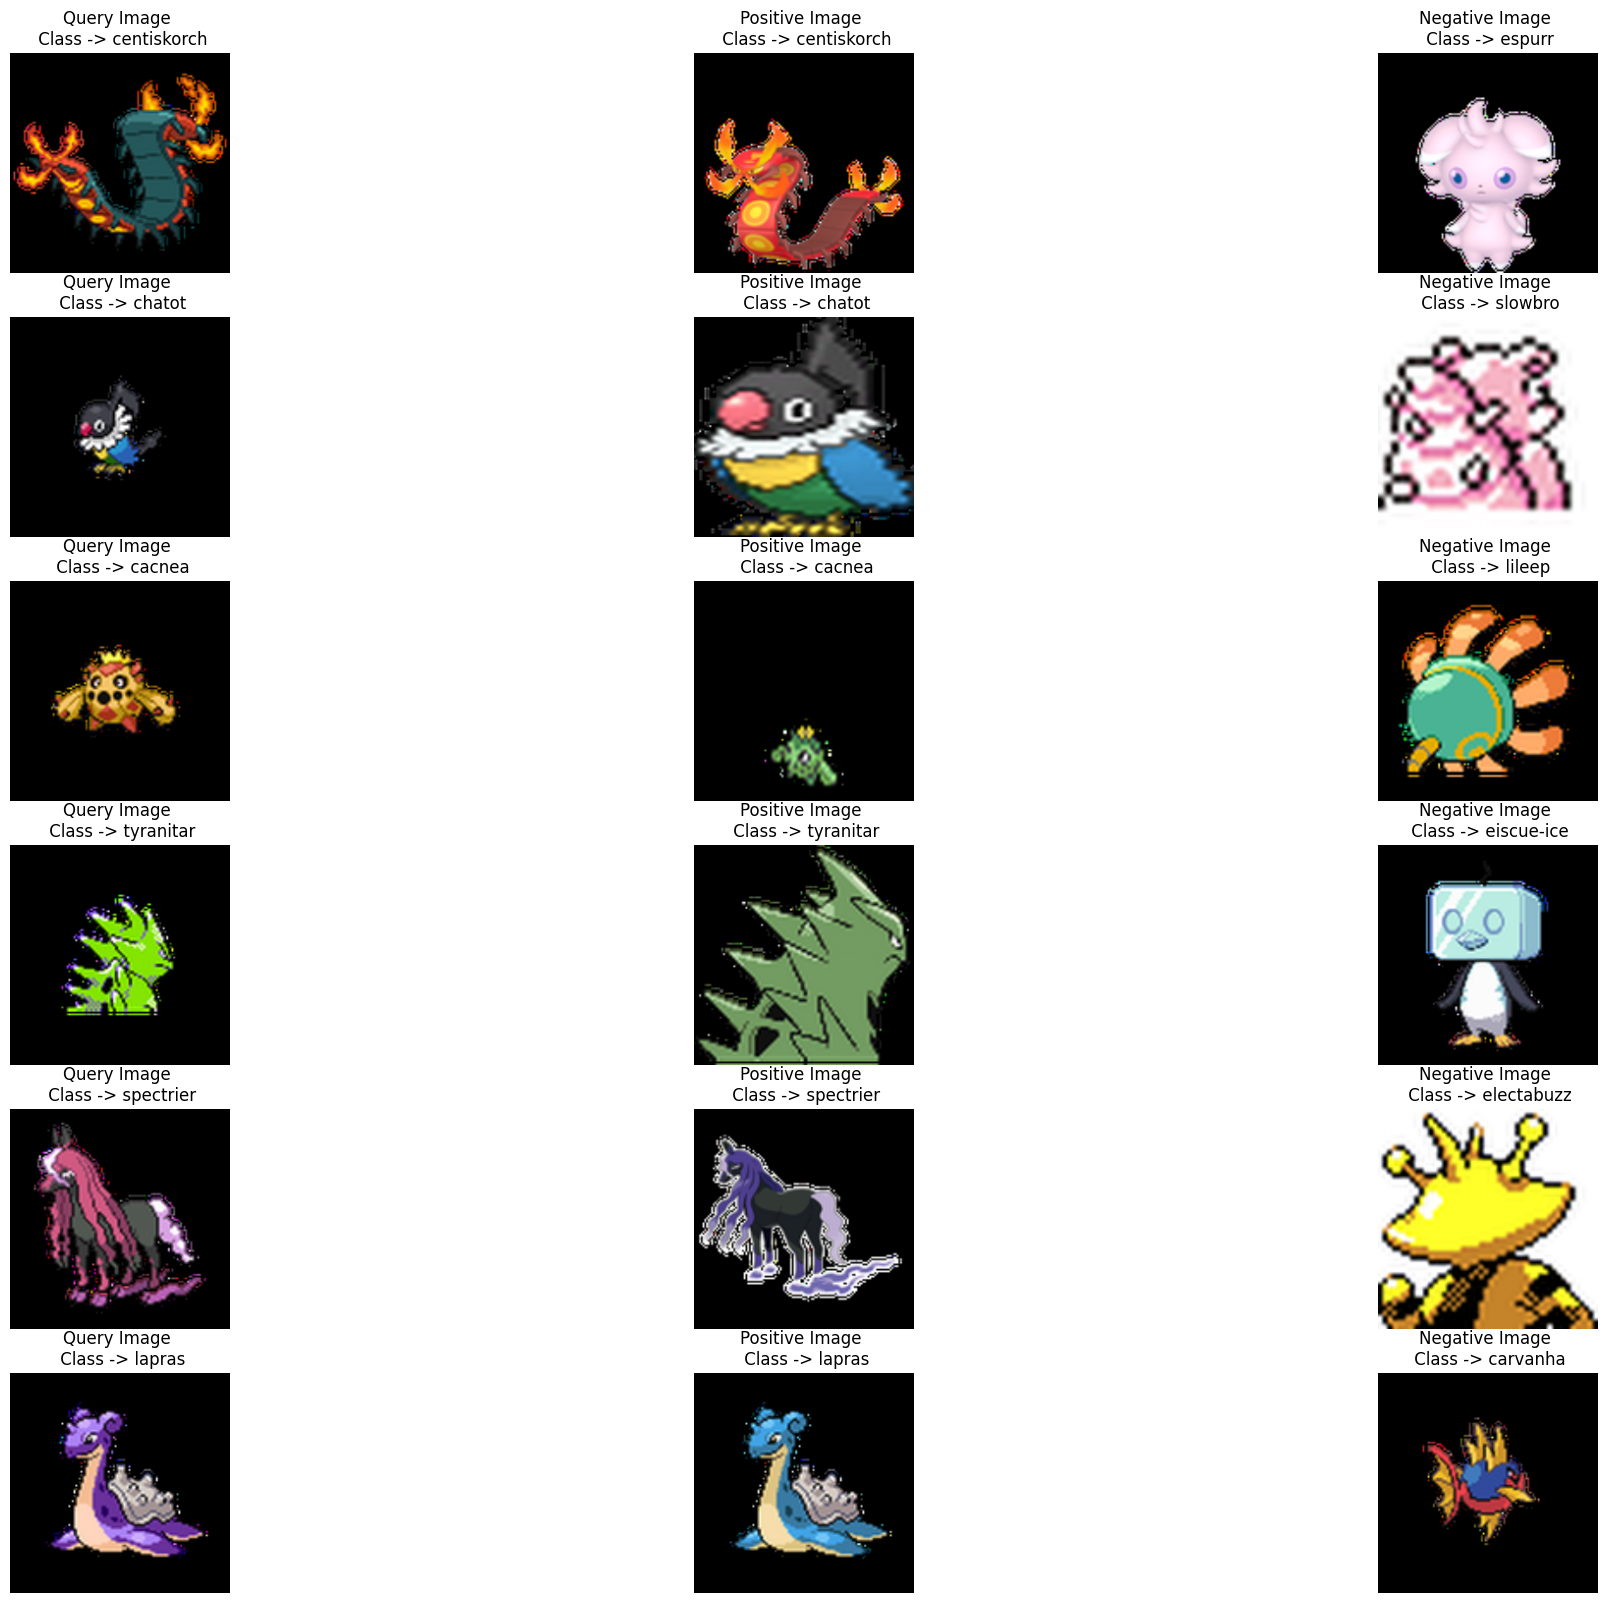

VAL Data Visualization is in process...



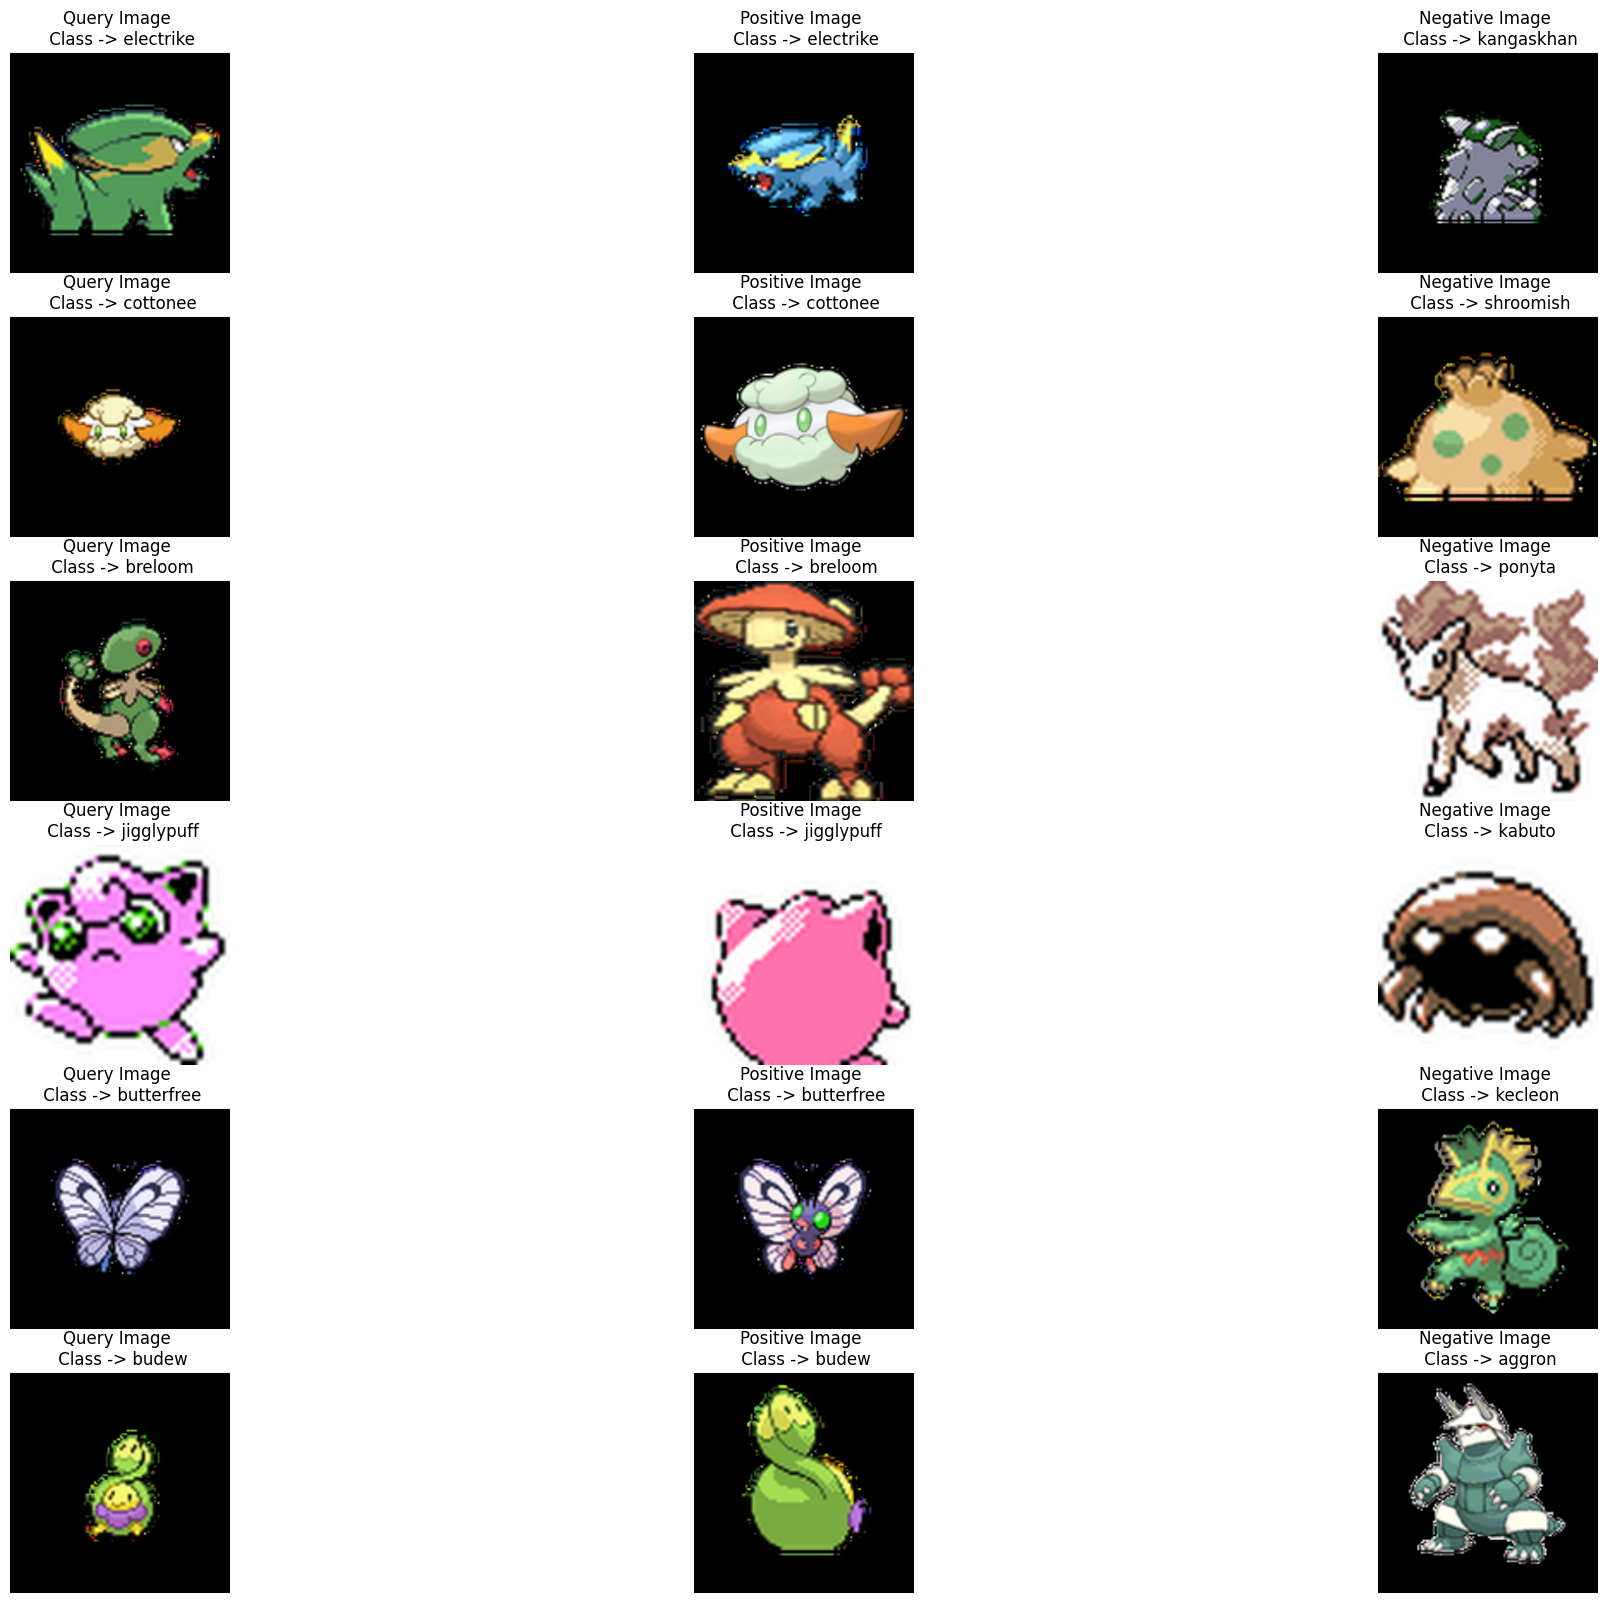

TEST Data Visualization is in process...



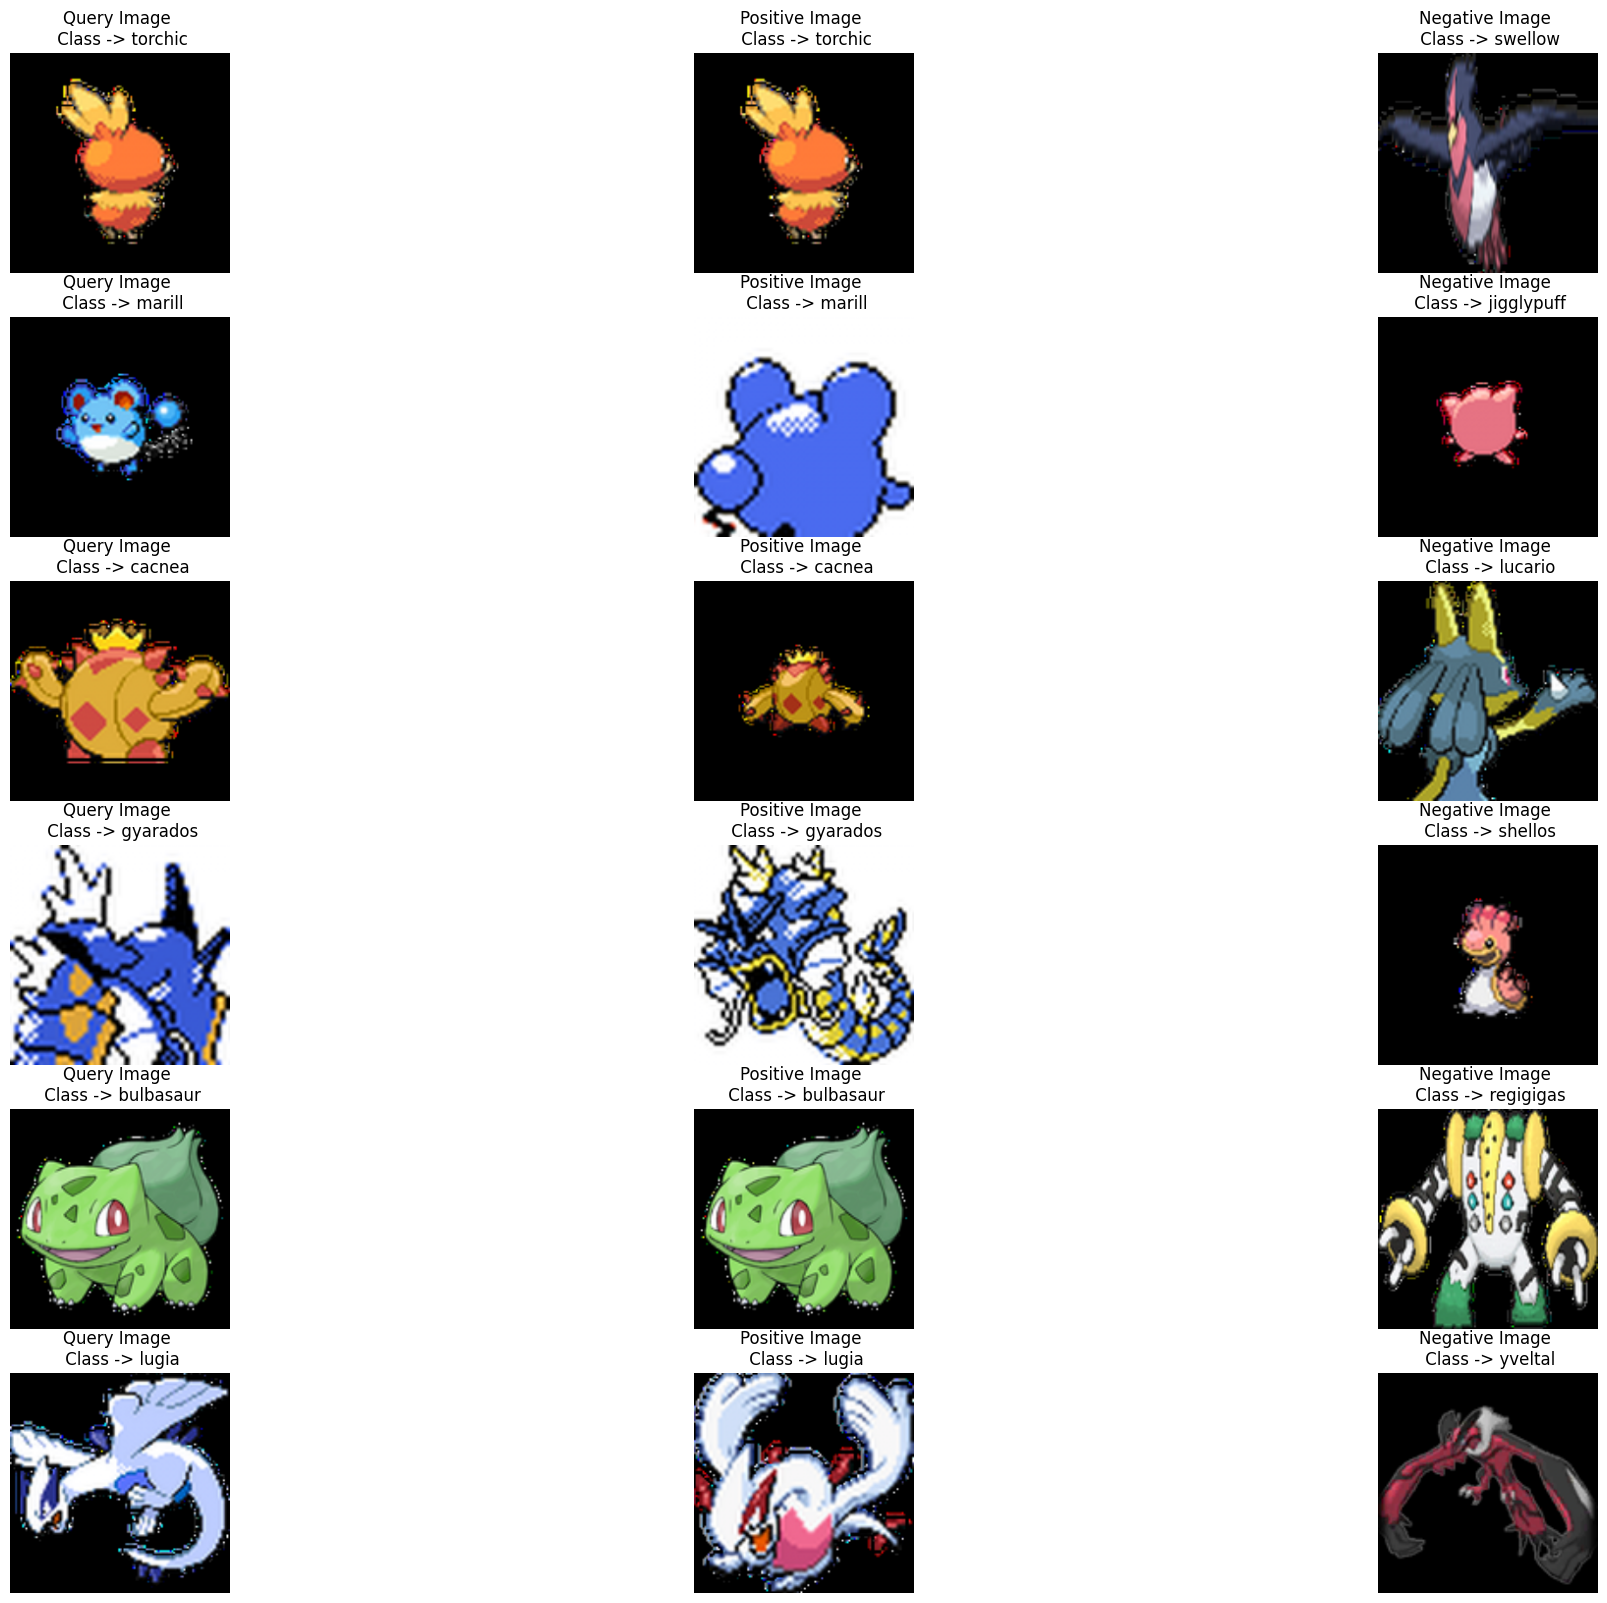

In [4]:
vis.visualization()

In [5]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 14.3 MB/s eta 0:00:00


<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>✨ 4. AI Model Train and Validation ✨</b></font>
</div>

In [6]:
import os, timm, torch, datetime
from torchmetrics.classification import MulticlassStatScores, MulticlassF1Score
from tqdm import tqdm
from time import time

class TrainValidation:

    def __init__(self, model_name, tr_dl, val_dl, classes, device, lr, save_dir,
                 run_name, data_name, epochs, project_name, bs, patience = 5, dev_mode = False):

        self.model_name, self.classes, self.device      = model_name, classes, device
        self.data_name, self.lr, self.save_dir, self.bs = data_name, lr, save_dir, bs
        self.tr_dl, self.val_dl, self.patience, self.dm = tr_dl, val_dl, patience, dev_mode
        self.run_name, self.epochs, self.project_name   = run_name, epochs, project_name
        self.run()

    def init_model(self): self.model = timm.create_model(self.model_name, pretrained = True, num_classes = len(self.classes))

    def init_lists(self): self.tr_losses, self.val_losses, self.tr_sens, self.val_senss, self.tr_specs, self.val_specs, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_times, self.vl_times = [], [], [], [], [], [], [], [], [], [], [], []

    def train_setup(self):

        self.best_loss, self.threshold, self.not_improved = float(torch.inf), 0.01, 0
        self.stop_train, self.tr_len, self.val_len        = False, len(self.tr_dl), len(self.val_dl)
        self.cs_lbls = {"cos_pos": torch.tensor(1.).unsqueeze(0), "cos_neg": torch.tensor(-1.).unsqueeze(0)}
        self.ckpt_path = f"{self.save_dir}/{self.data_name}_{self.run_name}_{self.model_name}_best_model.pth"
        run_name = f"{self.run_name}_{self.model_name}_bs_{self.bs}"

        str_time = str(datetime.datetime.now()).split(".")[0]

        self.model.to(self.device).eval()
        self.ce_loss_fn   = torch.nn.CrossEntropyLoss()
        self.cs_loss_fn   = torch.nn.CosineEmbeddingLoss(margin = 0.3)
        self.optimizer   = torch.optim.Adam(params = self.model.parameters(), lr = self.lr)
        self.f1_score    = MulticlassF1Score(num_classes = len(self.classes), average = "micro").to(self.device)
        self.stat_scores = MulticlassStatScores(num_classes = len(self.classes), average = "micro").to(self.device)

    def makedirs(self, path): os.makedirs(path, exist_ok = True)

    def get_fms(self, fms):

        """
        s
        This function gets feature map with size (bs, fm_shape, 7, 7)
        applies average pooling and returns feature map with shape (bs, fm_shape).

        Parameter:

            fm - feature map, tensor.

        Output:

            fm - reshaped feature map, tensor.

        """

        pool = torch.nn.AvgPool2d((fms[0].shape[2], fms[0].shape[3]))

        return [torch.reshape(pool(fm), (-1, fm.shape[1])) for fm in fms]

    def get_logits(self, ims): return [self.model.forward_features(im) for im in ims]

    def get_preds(self, fts): return [self.model.forward_head(ft) for ft in fts]

    def get_cs_loss(self, qry_fms, pos_fms, neg_fms): return self.cs_loss_fn(qry_fms, pos_fms, self.cs_lbls["cos_pos"].to(self.device)) + self.cs_loss_fn(qry_fms, neg_fms, self.cs_lbls["cos_neg"].to(self.device))

    def get_ce_loss(self, qry_preds, pos_preds, qry_lbls): return self.ce_loss_fn(qry_preds, qry_lbls) + self.ce_loss_fn(pos_preds, qry_lbls)

    def get_preds_loss(self, qry_ims, pos_ims, neg_ims, qry_lbls):

        # Get logits
        qry_logits, pos_logits, neg_logits = self.get_logits([qry_ims, pos_ims, neg_ims])
        qry_preds, pos_preds = self.get_preds([qry_logits, pos_logits])

        # Contrastive loss
        qry_fms, pos_fms, neg_fms = self.get_fms([qry_logits, pos_logits, neg_logits])
        cs_loss = self.get_cs_loss(qry_fms, pos_fms, neg_fms)

        # Cross entropy loss
        ce_loss = self.get_ce_loss(qry_preds, pos_preds, qry_lbls)

        # Final loss
        loss = cs_loss + ce_loss

        return torch.argmax(qry_preds, dim = 1), loss

    def eval_train_batch(self, preds, gts, loss):

        self.epoch_acc    += (preds == gts).sum().item()
        self.epoch_loss   += loss.item()
        self.epoch_f1     += self.f1_score(preds, gts)
        tp, fp, tn, fn, _  = self.stat_scores(preds, gts)
        self.spec         += tn / (tn + fp)
        self.sens         += tp / (tp + fn)

    def eval_valid_batch(self, preds, gts, loss):

        self.val_epoch_loss   += loss.item()
        self.val_epoch_acc    += (preds == gts).sum().item()
        self.val_epoch_f1     +=  self.f1_score(preds, gts)
        tp, fp, tn, fn, _      = self.stat_scores(preds, gts)
        self.val_spec         += tn / (tn + fp)
        self.val_sens         += tp / (tp + fn)

    def to_device(self, batch): return batch["qry_im"].to(self.device), batch["pos_im"].to(self.device), batch["neg_im"].to(self.device), batch["qry_gt"].to(self.device)

    def train_one_epoch(self, epoch):

        self.model.train()
        self.epoch_loss, self.epoch_acc, self.epoch_f1, self.loss, self.sens, self.spec = 0, 0, 0, 0, 0, 0

        tr_start = time();
        for idx, batch in tqdm(enumerate(self.tr_dl)):

            if self.dm:
                if idx == 1: break

            qry_ims, pos_ims, neg_ims, qry_im_lbls = self.to_device(batch)

            qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
            self.eval_train_batch(qry_preds, qry_im_lbls, loss)
            self.optimizer.zero_grad(); loss.backward(); self.optimizer.step()

        tr_time = time() - tr_start; self.tr_times.append(tr_time)
        tr_loss_to_track = self.epoch_loss / self.tr_len
        tr_sens_to_track = self.sens / self.tr_len
        tr_spec_to_track = self.spec / self.tr_len
        tr_acc_to_track  = self.epoch_acc  / len(self.tr_dl.dataset)
        tr_f1_to_track   = self.epoch_f1   / self.tr_len
        self.tr_losses.append(tr_loss_to_track); self.tr_accs.append(tr_acc_to_track); self.tr_f1s.append(tr_f1_to_track); self.tr_sens.append(tr_sens_to_track); self.tr_specs.append(tr_spec_to_track)

        print("\n~~~~~~~~~~~~~~~~~~~~ TRAIN PROCESS STATS ~~~~~~~~~~~~~~~~~~~~")
        print(f"\n{epoch + 1}-epoch train process is completed!\n")
        print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch train spec          -> {tr_spec_to_track:.3f}")
        print(f"{epoch + 1}-epoch train sens          -> {tr_sens_to_track:.3f}")
        print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    def eval_one_epoch(self, epoch):

        self.val_epoch_loss, self.val_epoch_acc, self.val_epoch_f1, self.val_sens, self.val_spec = 0, 0, 0, 0, 0
        self.model.eval()
        with torch.no_grad():
            vl_start = time()
            for idx, batch in enumerate(self.val_dl):

                if self.dm:
                    if idx == 1: break

                qry_ims, pos_ims, neg_ims, qry_im_lbls = self.to_device(batch)

                qry_preds, loss = self.get_preds_loss(qry_ims, pos_ims, neg_ims, qry_im_lbls)
                self.eval_valid_batch(qry_preds, qry_im_lbls, loss)

            vl_time = time() - vl_start; self.vl_times.append(vl_time)
            val_loss_to_track = self.val_epoch_loss  / self.val_len
            val_sens_to_track = self.val_sens / self.val_len
            val_spec_to_track = self.val_spec / self.val_len
            val_acc_to_track  = self.val_epoch_acc   / len(self.val_dl.dataset)
            val_f1_to_track   = self.val_epoch_f1    / self.val_len
            self.val_losses.append(val_loss_to_track); self.val_accs.append(val_acc_to_track); self.val_f1s.append(val_f1_to_track); self.val_senss.append(val_sens_to_track); self.val_specs.append(val_spec_to_track)

            print(f"\n{epoch + 1}-epoch validation process is completed!\n")
            print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation spec     -> {val_spec_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation sens     -> {val_sens_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
            print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

            print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        return val_loss_to_track

    def save_best_model(self): torch.save(self.model.state_dict(), self.ckpt_path); print("Pretrained weights of the model with lowest loss are successfully saved!")

    def epoch_summary(self, metric):

        if (metric + self.threshold) < self.best_loss:

            print(f"\nValidation loss is decreased from {self.best_loss:.5f} to {metric:.5f}")
            print("Saving the best model with the lowest loss value...\n")
            self.best_loss = metric
            self.save_best_model()

        else:

            self.not_improved += 1
            print(f"\nValidation loss is not significantly decreased from {self.best_loss:.5f}. The current epoch loss is {metric:.5f}.")
            print(f"Validation loss value did not decrease for {self.not_improved} epochs")
            if self.not_improved == self.patience:
                print(f"Stop training since loss value did not decrease for {self.patience} epochs.")
                self.stop_train = True

    def train(self):

        print("Start training...")
        for epoch in range(self.epochs):
            if self.dm:
                if epoch == 1: break
            self.train_one_epoch(epoch); loss = self.eval_one_epoch(epoch)
            self.epoch_summary(loss)
            if self.stop_train: break

    def get_stats(self): return [self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s, self.tr_specs, self.val_specs, self.tr_sens, self.val_senss, self.tr_times, self.vl_times]

    def run(self): self.makedirs(self.save_dir); self.init_lists(); self.init_model(); self.train_setup(); self.train()

In [ ]:
project_name, run_name, model_name   = "kaggle", "triplet", "rexnet_150"
save_dir, data_name, epochs, device  = "saved_models", "pokemon", 20, "cuda"

results = TrainValidation(model_name = model_name, tr_dl = tr_dl, val_dl = val_dl,
                          classes = classes, device = device, lr = 3e-4, save_dir = save_dir,
                          data_name = data_name, project_name = project_name, bs = bs, run_name = run_name,
                          epochs = epochs, patience = 3, dev_mode = False).get_stats()

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>😍 5. Learning Curves 😍</b></font>
</div>

In [7]:
class TrainProcessSummary:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s,
                 val_f1s, tr_specs, val_spec, tr_sens, val_sens, tr_times,
                 vl_times, data_name, save_path = "stats"):

        self.makedirs(save_path)
        self.xlbl, self.times_sv_name   = "Epochs", "times.png"
        self.data_name, self.save_path  = data_name, save_path
        self.tr_losses, self.val_losses = tr_losses, val_losses
        self.tr_accs,   self.val_accs   = tr_accs, val_accs
        self.tr_f1s,    self.val_f1s    = tr_f1s, val_f1s
        self.tr_specs,  self.val_spec   = tr_specs, val_spec
        self.tr_sens,   self.val_sens   = tr_sens, val_sens
        self.tr_times,  self.vl_times   = tr_times, vl_times
        self.get_ticks_labels(); self.learning_curves(); self.bar_plot()

        print(f"Learning curves can be found in {self.save_path}\n")
        print(f"Train times can be found in {self.save_path} directory under the name {self.times_sv_name}\n")

    def get_ticks_labels(self): self.xtics, self.xlabels = np.arange(len(self.tr_losses)), [i for i in range(1, len(self.tr_losses) + 1)]

    def makedirs(self, path): os.makedirs(path, exist_ok = True)

    def create_figure(self):    plt.figure(figsize = (10, 5))

    def move2cpu(self, data):   return [d.cpu() for d in data]

    def plot(self, data1, data2, plot_name, c1, c2):

        self.create_figure()
        need2bemoved = ["Sensitivity", "Specificity", "F1"]
        if plot_name in need2bemoved: data1 = self.move2cpu(data1); data2 = self.move2cpu(data2)
        label = f"{plot_name} Scores"
        plt.plot(data1, label = f"Train {label}", color = c1); plt.plot(data2, label = f"Validation {label}", color = c2)
        plt.xlabel(self.xlbl); plt.ylabel(label); plt.title(f"Train and Validation {label}")
        plt.xticks(ticks = self.xtics, labels = self.xlabels); plt.legend(); plt.show()

    def save(self, save_name):

        sv_name = f"{self.data_name}_{save_name}"
        plt.savefig(f"{self.save_path}/{sv_name}")

    def learning_curves(self):

        self.plot(self.tr_losses, self.val_losses, "Loss",        "red",        "blue");         self.save("losses.png")
        self.plot(self.tr_accs,   self.val_accs,   "Accuracy",     "orangered",  "darkgreen");   self.save("accs.png")
        self.plot(self.tr_f1s,    self.val_f1s,    "F1",          "aquamarine", "greenyellow");  self.save("f1s.png")
        self.plot(self.tr_specs,  self.val_spec,   "Specificity", "violet",     "dodgerblue");   self.save("specs.png")
        self.plot(self.tr_sens,   self.val_sens,   "Sensitivity", "gold",       "lightcoral");   self.save("sens.png")

    def bar_plot(self):

        self.create_figure();

        plt.bar(self.xtics - 0.2, self.tr_times, 0.4, label = "Train")
        plt.bar(self.xtics + 0.2, self.vl_times, 0.4, label = "Validation")

        plt.xticks(self.xtics);   plt.xlabel(self.xlbl)
        plt.ylabel("Seconds");    plt.title("Train and Validation Times")
        plt.legend(); plt.show(); self.save(self.times_sv_name)

results = [
    tr_losses, val_losses,
    tr_accs, val_accs,
    tr_f1s, val_f1s,
    tr_specs, val_specs,
    tr_sens, val_sens,
    tr_times, vl_times
]

TrainProcessSummary(*results, data_name = data_name)

NameError: name 'tr_losses' is not defined

<div style='background-color: #fff7f7; border: 2px solid '>
    <font size="+2" color="blue" ><b>✅ 6. Inference and AI Model Performance Analysis with GradCAM ✅</b></font>
</div>

In [ ]:
!pip install grad-cam==1.4.6
import cv2, seaborn as sns
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.metrics import confusion_matrix

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def plot_value_array(logits, gt, cls_names):

    probs = torch.nn.functional.softmax(logits, dim = 1)
    pred_score, pred_class = torch.max(probs, dim = 1)

    plt.grid(visible = True)
    plt.xticks(range(len(cls_names)), cls_names, rotation='vertical')
    plt.yticks(np.arange(start = 0., stop = 1.01, step = 0.1))
    bar = plt.bar(range(len(cls_names)), [p.item() for p in probs[0]], color="#777777")
    plt.ylim([0, 1])
    # Color the bars based on the criteria
    bar[pred_class].set_color('green') if pred_class.item() == gt else bar[pred_class].set_color('red')

def inference(model, device, test_dl, num_ims, row, cls_names = None, im_size = size):

    with torch.no_grad():
        preds, images, lbls, logitss = [], [], [], []
        acc, count                   = 0, 1
        for idx, batch in tqdm(enumerate(test_dl)):
            if idx == num_ims: break
            im, gt = batch["qry_im"].to(device), batch["qry_gt"].to(device)
            logits  = model(im)
            pred_class   = torch.argmax(logits, dim = 1)
            acc += (pred_class == gt).sum().item()
            images.append(im)
            logitss.append(logits)
            preds.append(pred_class)
            lbls.append(gt.item())

        print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")

    plt.figure(figsize = (20, 10))
    cam = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]], use_cuda = False)
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    for idx, indeks in enumerate(indekslar):

        im = tensor_2_im(images[indeks].squeeze())
        pred_idx = preds[indeks]

        # Start plot
        plt.subplot(row, 2 * num_ims // row, count); count += 1
        plt.imshow(im, cmap = "gray"); plt.axis("off")

        grayscale_cam = cam(input_tensor=images[indeks])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(im / 255, grayscale_cam, image_weight=0.4, use_rgb = True)
        plt.imshow(cv2.resize(visualization, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.7, cmap='jet'); plt.axis("off")
        plt.subplot(row, 2 * num_ims // row, count); count += 1
        plot_value_array(logits = logitss[indeks], gt = lbls[indeks], cls_names = cls_names)

        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

    plt.figure(figsize = (20, 10))
    sns.heatmap(confusion_matrix([pred.detach().cpu().numpy() for pred in preds], lbls), annot=True, fmt='d', xticklabels=cls_names, yticklabels=cls_names)
    plt.title("Confusion Matrix")

model = timm.create_model(model_name = model_name, num_classes = len(classes))
model.load_state_dict(torch.load(f"{save_dir}/{data_name}_{run_name}_{model_name}_best_model.pth"))
model.eval()
inference(model = model.to(device), device = device, test_dl = ts_dl, num_ims = 10, row = 2, cls_names = list(classes.keys()))